In [1]:
#Global Imports

import pandas as pd
import random, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline

In [2]:
#Seed the random number generator.

def seed_env(seed_var=0):
    random.seed(seed_var)
    os.environ['PYTHONHASHSEED'] = str(seed_var)
    np.random.seed(seed_var)
    
seed_value = 42
seed_env(seed_value)

In [3]:
#Load in the four files.

df1 = pd.read_csv('./data_in/test_identity.csv')
df2 = pd.read_csv('./data_in/test_transaction.csv')
df3 = pd.read_csv('./data_in/train_identity.csv')
df4 = pd.read_csv('./data_in/train_transaction.csv')

#Print the shape of the four dataframes.
print('Shape of df1: {}'.format(df1.shape))
print('Shape of df2: {}'.format(df2.shape))
print('Shape of df3: {}'.format(df3.shape))
print('Shape of df4: {}'.format(df4.shape))

Shape of df1: (141907, 41)
Shape of df2: (506691, 393)
Shape of df3: (144233, 41)
Shape of df4: (590540, 394)


In [4]:
#Concatenate the two identity and two transaction dataframes into one.

df_identity = pd.concat([df1, df3], sort=False)
df_transaction = pd.concat([df2, df4], sort=False)

### Find all of the float variables in `df_identity'

Once we find all of the float columns, we'll also print out the descriptive stats for these variables. At first pass, the varibles that are floats may not be relevant. I need to check into this more.

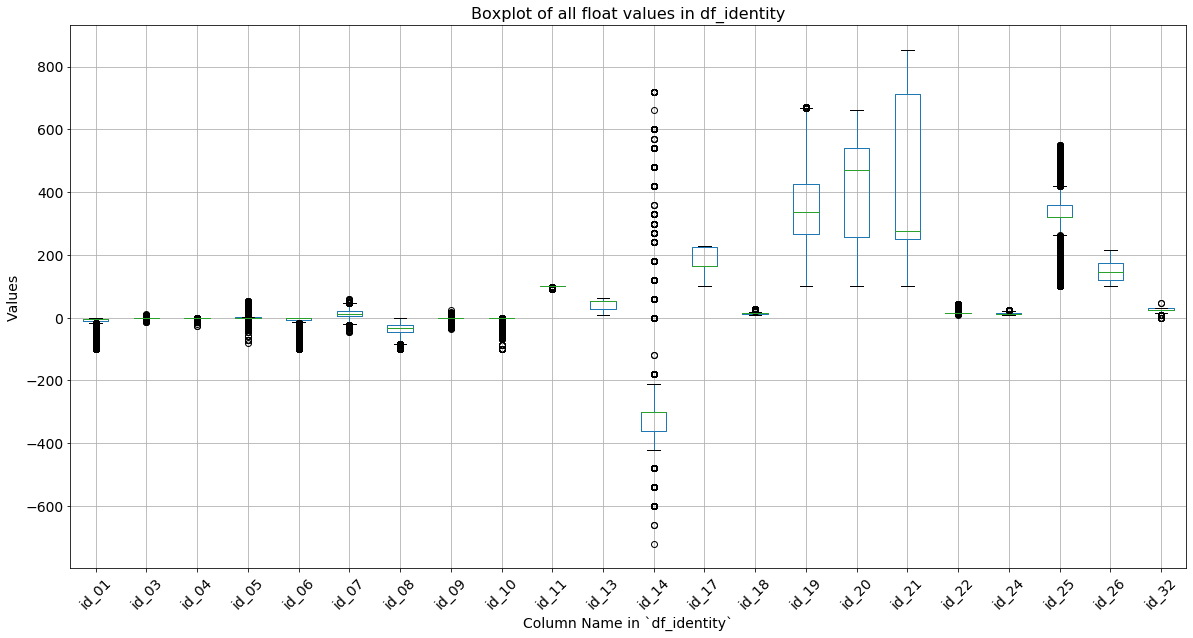

In [5]:
#Boxplot of the `float` features.

plt.figure(figsize=(20, 10))
df_identity[df_identity.columns[df_identity.dtypes == float].tolist()].drop(["id_02"], axis=1).boxplot()
plt.ylabel('Values', fontsize = 14)
plt.yticks(fontsize=14)
plt.xlabel('Column Name in `df_identity`', fontsize = 14)
plt.xticks(fontsize=14, rotation=45)
plt.title('Boxplot of all float values in df_identity', fontsize=16)
plt.show()

In [6]:
#Check shape of new dataframe.
df_identity.shape

(286140, 41)

In [7]:
#Check shape of new dataframe.
df_transaction.shape

(1097231, 394)

In [8]:
# Merge the two dataframes on the transction id.

df = pd.merge(df_identity, df_transaction, on='TransactionID', how='inner')
#df.to_csv('merged_csv.csv', index=False)

In [9]:
#Check shape of new dataframe.

df.shape

(286140, 434)

In [10]:
#Remove any columns that have more than 90% of the values missing.
df = df.loc[:, df.isnull().mean() < 0.9]

#Remove any rows that have a NaN in the 'isFraud' column.
df = df[pd.notnull(df['isFraud'])]

In [11]:
#Check shape of new dataframe.

df.shape

(144233, 404)

In [12]:
#Check the number of entries in each class. 

df['isFraud'].value_counts()

0.0    132915
1.0     11318
Name: isFraud, dtype: int64

In [13]:
#Look at the unique data type in the df.
set(df.dtypes.tolist())

{dtype('int64'), dtype('float64'), dtype('O')}

In [14]:
#Store the column names based on the data type.

cat_cols = df.columns[df.dtypes == object].tolist()
int_cols = df.columns[df.dtypes == int].tolist()
float_cols = df.columns[df.dtypes == float].tolist()

In [15]:
float_cols[:5]

['id_01', 'id_02', 'id_03', 'id_04', 'id_05']

In [16]:
#These fields need to be standardized using standard scaler. 
len(float_cols)

380

In [17]:
#High cardinality columns. We will remove these from the dataset. 
print('Total number of unique values: {}'.format(len(df[int_cols]['card1'].value_counts())))
print('Total Number of Features: {}'.format(int_cols))

Total number of unique values: 8499
Total Number of Features: ['TransactionID', 'TransactionDT', 'card1']


In [18]:
cat_cols[:5]

['id_12', 'id_15', 'id_16', 'id_28', 'id_29']

In [19]:
#These fields need to be encoded using onehotencoding.
len(cat_cols)

21

## Initial EDA
From the inital review, it seems that all of the columns that have int values can be removed from the dataset. 
This includes `['TransactionID', 'TransactionDT', 'card1']`. We also need to remove the target column `isFraud`.

### Approach
For the first iteration of the model, we'll take the features in `X[cat_cols].columns.tolist()` and add to that, `'TransactionAmt'` from `X[float_cols].columns.tolist()` and use that as the initial dataset for logistic regression. 

Once the dataset is created, we'll need to impute missing values for both the categorical and continious values, and then proceed to using `StandardScaler` and `onehotencoding` to create the final dataset that can be used for machine learning. To do this, we'll use the `ColumnTransformer` and `Pipeline` methods in sklearn. We can also include the classification model into the `Pipeline` framework.

When it comes to missing data, for the categorical values, we'll include the term `Missing` and for the continious variables, we'll impute the median value as the missing values for this round of development.

In [20]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 141907 to 286139
Data columns (total 21 columns):
id_12            144233 non-null object
id_15            140985 non-null object
id_16            129340 non-null object
id_28            140978 non-null object
id_29            140978 non-null object
id_30            77565 non-null object
id_31            140282 non-null object
id_33            73289 non-null object
id_34            77805 non-null object
id_35            140985 non-null object
id_36            140985 non-null object
id_37            140985 non-null object
id_38            140985 non-null object
DeviceType       140810 non-null object
DeviceInfo       118666 non-null object
ProductCD        144233 non-null object
card4            144049 non-null object
card6            144055 non-null object
P_emaildomain    130842 non-null object
R_emaildomain    131083 non-null object
M4               60831 non-null object
dtypes: object(21)
memory usage: 24.2+ MB


In [21]:
df[float_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id_01,144233.0,-10.170502,14.347949,-100.0,-10.0,-5.0,-5.0,0.0
id_02,140872.0,174716.584708,159651.816856,1.0,67992.0,125800.5,228749.0,999595.0
id_03,66324.0,0.060189,0.598231,-13.0,0.0,0.0,0.0,10.0
id_04,66324.0,-0.058938,0.701015,-28.0,0.0,0.0,0.0,0.0
id_05,136865.0,1.615585,5.249856,-72.0,0.0,0.0,1.0,52.0
...,...,...,...,...,...,...,...,...
V336,82041.0,28.592672,275.048519,0.0,0.0,0.0,0.0,55125.0
V337,82041.0,55.461163,669.707372,0.0,0.0,0.0,0.0,104060.0
V338,82041.0,151.546395,1096.739466,0.0,0.0,0.0,0.0,104060.0
V339,82041.0,100.950114,816.354359,0.0,0.0,0.0,0.0,104060.0


In [22]:
df[float_cols].columns.tolist()[:5]
#Out of all of tehse fields, `'TransactionAmt'` may be the best feature.

['id_01', 'id_02', 'id_03', 'id_04', 'id_05']

In [23]:
df[cat_cols].columns.tolist()

['id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M4']

In [24]:
final_feat_list = cat_cols

#This adds 'TransactionAmt' to the list inplace.
final_feat_list.append('TransactionAmt')
final_feat_list.append('isFraud')

In [25]:
df[final_feat_list].head(3).T

,141907,141908,141909
id_12,NotFound,NotFound,NotFound
id_15,New,New,Found
id_16,NotFound,NotFound,Found
id_28,New,New,Found
id_29,NotFound,NotFound,Found
id_30,Android 7.0,iOS 11.1.2,NaN
id_31,samsung browser 6.2,mobile safari 11.0,chrome 62.0
id_33,2220x1080,1334x750,NaN
id_34,match_status:2,match_status:1,NaN
id_35,T,T,F


In [26]:
df[final_feat_list].columns.tolist()

['id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M4',
 'TransactionAmt',
 'isFraud']

In [27]:
df = df[final_feat_list]

In [28]:
#Handle missing data .

df['id_12'] = df['id_12'].fillna('Missing')
df['id_15'] = df['id_15'].fillna('Missing')
df['id_16'] = df['id_16'].fillna('Missing')
df['id_28'] = df['id_28'].fillna('Missing')
df['id_29'] = df['id_29'].fillna('Missing')
df['id_30'] = df['id_30'].fillna('Missing')
df['id_31'] = df['id_31'].fillna('Missing')
df['id_33'] = df['id_33'].fillna('Missing')
df['id_34'] = df['id_34'].fillna('Missing')
df['id_35'] = df['id_35'].fillna('Missing')
df['id_36'] = df['id_36'].fillna('Missing')
df['id_37'] = df['id_37'].fillna('Missing')
df['id_38'] = df['id_38'].fillna('Missing')
df['DeviceType'] = df['DeviceType'].fillna('Missing')
df['DeviceInfo'] = df['DeviceInfo'].fillna('Missing')
df['M4'] = df['M4'].fillna('Missing')
df['P_emaildomain'] = df['P_emaildomain'].fillna('Missing')
df['ProductCD'] = df['ProductCD'].fillna('Missing')
df['R_emaildomain'] = df['R_emaildomain'].fillna('Missing')
df['card4'] = df['card4'].fillna('Missing')
df['card6'] = df['card6'].fillna('Missing')
df['TransactionAmt'] = df['TransactionAmt'].fillna(np.median)
df['isFraud'] = df['isFraud'].astype(int)

In [29]:
#Check that all of the missing values have been imputed.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 141907 to 286139
Data columns (total 23 columns):
id_12             144233 non-null object
id_15             144233 non-null object
id_16             144233 non-null object
id_28             144233 non-null object
id_29             144233 non-null object
id_30             144233 non-null object
id_31             144233 non-null object
id_33             144233 non-null object
id_34             144233 non-null object
id_35             144233 non-null object
id_36             144233 non-null object
id_37             144233 non-null object
id_38             144233 non-null object
DeviceType        144233 non-null object
DeviceInfo        144233 non-null object
ProductCD         144233 non-null object
card4             144233 non-null object
card6             144233 non-null object
P_emaildomain     144233 non-null object
R_emaildomain     144233 non-null object
M4                144233 non-null object
TransactionAmt    14423

In [30]:
#Store the categorical features in a list
#Store the numerical features in a list.

cat_features = df.columns[df.dtypes == object].tolist()
num_features = df.columns[df.dtypes == float].tolist()

In [31]:
#Set up the Pipeline and transformer to process the data. 

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocesser = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

clf = Pipeline(steps=[
    ('preprocesser', preprocesser),
    ('classifier', LogisticRegression(solver='lbfgs', random_state=42))
])

In [32]:
#Create the feature and response variables. 

X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [33]:
#Split the data into training and testing. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [34]:
#Fit the data to the Pipeline.
clf.fit(X_train, y_train)

/Users/gta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('preprocesser',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['TransactionAmt']),
                                                 ('cat',
                                                  Pipeline(me

In [35]:
y_pred_class = clf.predict(X_test)

In [36]:
confusion_matrix(y_test, y_pred_class)

array([[33094,   139],
       [ 2396,   430]])

In [37]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

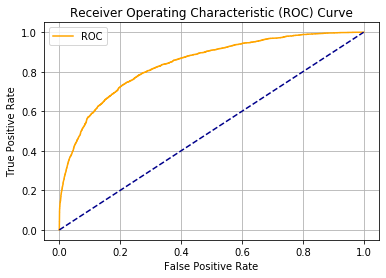

In [38]:
y_pred_proba = clf.predict_proba(X_test)
proba = y_pred_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
plot_roc_curve(fpr, tpr)

In [39]:
auc = roc_auc_score(y_test, proba)
print('AUC: {0:.3f}'.format(auc))

AUC: 0.841


### Final Thoughts

The accuracy of the model is `84.1%`. Given that the null accuracy of the dataset (i.e, accuracy of the model if the model always predicts the most common class), is `92.1%` there is more work that we can do on this model.  Areas for improvement include: random over/undersampling to account for the class imbalance as well as doing a gridsearch to find the optimal model parameters. We can also explore the use or exclusion of other features in the dataset and conduct k-fold cross validation.

These changes will be made on the next round of the model.